# KNN e SVM

KNN ou K-Nearest Neighbors é um algoritmo de classificação supervisionado. A classificação é feita por uma votação majoritária dos vizinhos mais próximos do objeto a ser classificado.

SVM ou Support Vector Machine é um algoritmo de classificação supervisionado. A classificação é feita por um hiperplano que separa os dados em classes. O hiperplano é escolhido de forma que a margem entre as classes seja a maior possível.

# Recrutamento preditivo

A empresa de tecnologia HighTech busca contratar os melhores profissionais do mercado para fazer parte do time e gerar valor para a empresa. A HighTech vem investindo muito nos últimos anos no uso de ciência de dados no setor do RH para trazer ganhos no processo de seleção e recrutamento. O time de ciência de dados junto com o time de RH vem realizando juntos um projeto de recrutamento preditivo.

O recrutamento preditivo é uma técnica de People Analytics para encontrar os melhores candidatos para contratação da empresa, na prática, o recrutamento preditivo aumenta as chances do recrutador potencializar o processo de seleção. Por meio da coleta e análise de dados, é possível avaliar o perfil e o fit cultural dos profissionais para entender se existe uma boa aderência à vaga. 

**Problema de negócio:**

O objetivo da HighTech é identificar quais são os melhores indicadores para realizar o recrutamento de profissionais. 

**Base de dados**

Este conjunto de dados consiste em algumas características como: percentual de ensino médio e superior e especialização, experiência de trabalho e ofertas salariais para os profissionais colocados.

**Desafio**

Você como cientista de dados do time de dados da HighTech tem o desafio de criar um modelo preditivo de recrutamento para prever como e quais são as melhores variáveis que podem colocar um profissional bem qualificado na HighTech.

In [152]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import missingno as msno

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline

## Exploração dos dados

In [48]:
df = pl.read_excel('data/recrutamento.xlsx')
df.sample(5)

sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
i64,str,f64,str,f64,str,str,f64,str,str,f64,str,f64,str,i64
135,"""F""",77.44,"""Central""",92.0,"""Others""","""Commerce""",72.0,"""Comm&Mgmt""","""Yes""",94.0,"""Mkt&Fin""",67.13,"""Yes""",250000
201,"""M""",69.0,"""Others""",60.0,"""Others""","""Commerce""",65.0,"""Comm&Mgmt""","""No""",87.55,"""Mkt&Fin""",52.81,"""Yes""",300000
170,"""M""",59.96,"""Others""",42.16,"""Others""","""Science""",61.26,"""Sci&Tech""","""No""",54.48,"""Mkt&HR""",65.48,"""No""",null
37,"""M""",51.0,"""Central""",44.0,"""Central""","""Commerce""",57.0,"""Comm&Mgmt""","""No""",64.0,"""Mkt&Fin""",51.45,"""No""",null
13,"""F""",47.0,"""Central""",55.0,"""Others""","""Science""",65.0,"""Comm&Mgmt""","""No""",62.0,"""Mkt&HR""",65.04,"""No""",null


In [49]:
df.shape

(215, 15)

In [50]:
df.select('status').to_series().value_counts()

status,counts
str,u32
"""Yes""",148
"""No""",67


In [51]:
df.describe()

describe,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
str,f64,str,f64,str,f64,str,str,f64,str,str,f64,str,f64,str,f64
"""count""",215.0,"""215""",215.0,"""215""",215.0,"""215""","""215""",215.0,"""215""","""215""",215.0,"""215""",215.0,"""215""",215.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""",0.0,"""0""","""0""",0.0,"""0""",0.0,"""0""",67.0
"""mean""",108.0,null,67.303395,null,66.333163,null,null,66.370186,null,null,72.100558,null,62.278186,null,288655.405405
"""std""",62.209324,null,10.827205,null,10.897509,null,null,7.358743,null,null,13.275956,null,5.833385,null,93457.45242
"""min""",1.0,"""F""",40.89,"""Central""",37.0,"""Central""","""Arts""",50.0,"""Comm&Mgmt""","""No""",50.0,"""Mkt&Fin""",51.21,"""No""",200000.0
"""25%""",54.0,null,60.4,null,60.8,null,null,61.0,null,null,60.0,null,57.9,null,240000.0
"""50%""",108.0,null,67.0,null,65.0,null,null,66.0,null,null,71.0,null,62.0,null,265000.0
"""75%""",162.0,null,76.0,null,73.0,null,null,72.0,null,null,84.0,null,66.28,null,300000.0
"""max""",215.0,"""M""",89.4,"""Others""",97.7,"""Others""","""Science""",91.0,"""Sci&Tech""","""Yes""",98.0,"""Mkt&HR""",77.89,"""Yes""",940000.0


Vamos verificar os dados nulos

<Axes: >

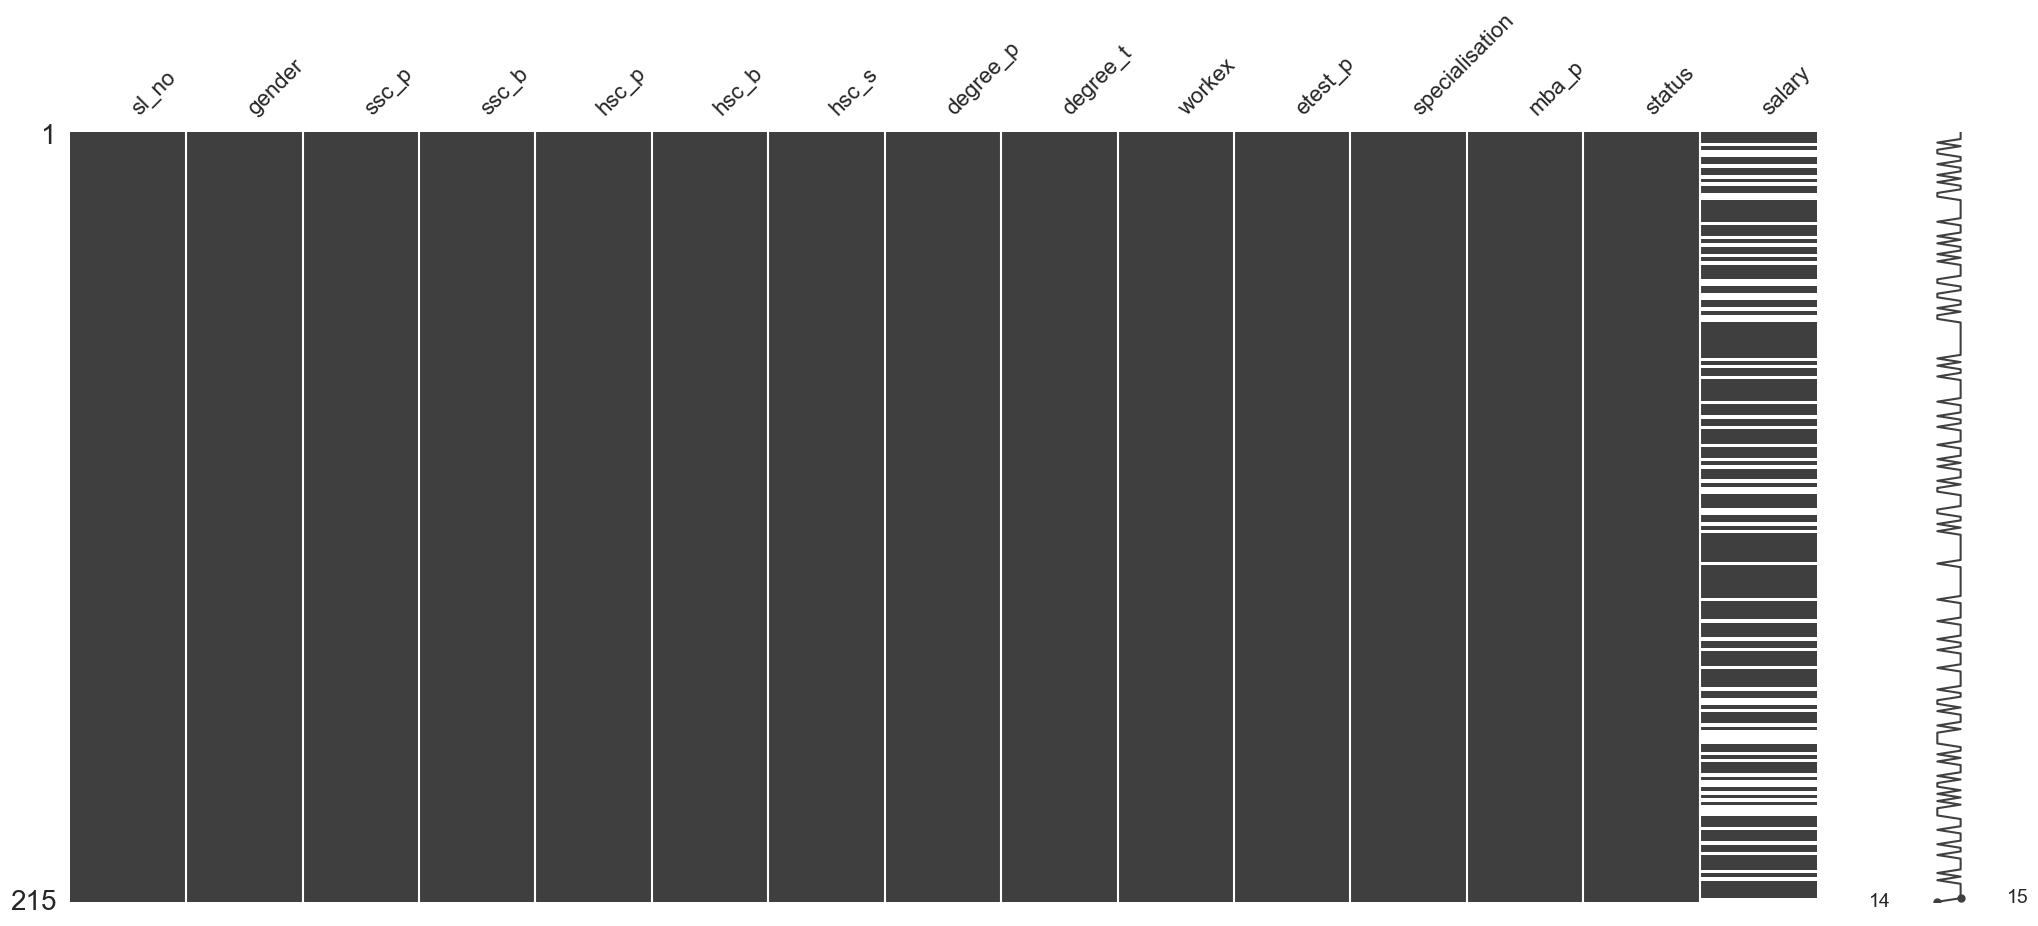

In [52]:
msno.matrix(df.to_pandas())

In [53]:
df.select(pl.all().null_count())

sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,67


Vamos verificar esses dados nulos em relação à nossa variável target

<Axes: xlabel='status', ylabel='salary'>

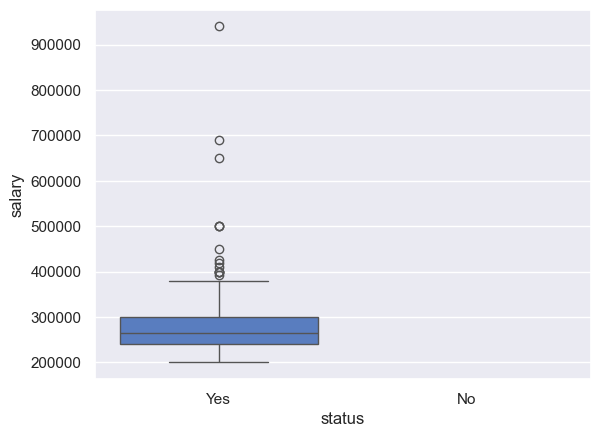

In [54]:
sns.boxplot(data=df, x='status', y='salary')

Podemos perceber que a variável salário é atribuida após a contratação, não se refere a um histórico, e por tanto, não é uma variável que podemos utilizar para prever a contratação.

Vamos analisar outras variáveis

<Axes: xlabel='hsc_p'>

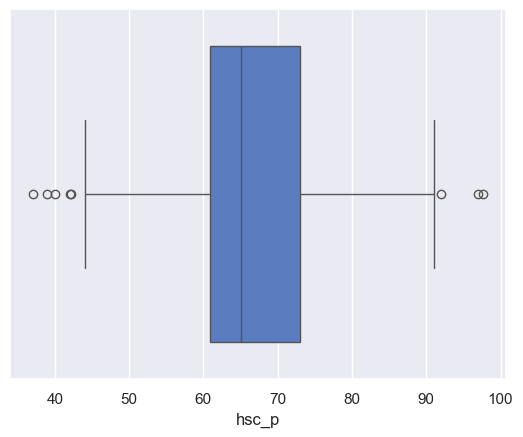

In [55]:
sns.boxplot(data=df, x='hsc_p')

<Axes: xlabel='hsc_p', ylabel='Count'>

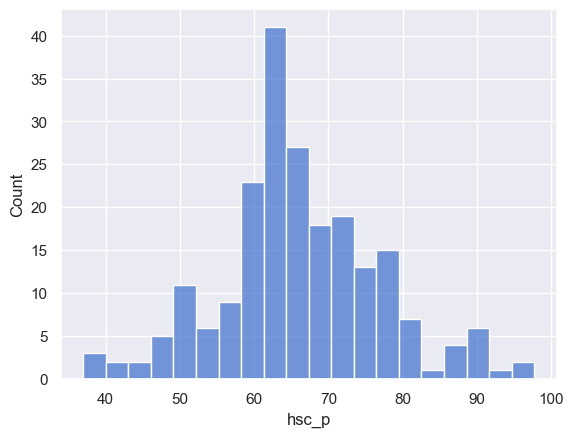

In [56]:
sns.histplot(data=df, x='hsc_p', bins=20)

<Axes: xlabel='degree_p'>

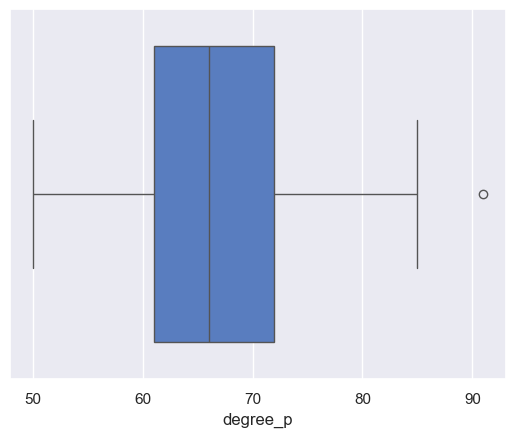

In [57]:
sns.boxplot(data=df, x='degree_p')

<Axes: xlabel='degree_p', ylabel='Count'>

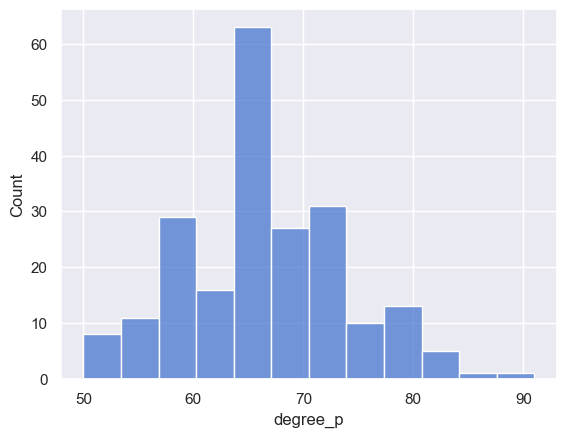

In [58]:
sns.histplot(data=df, x='degree_p')

<Axes: xlabel='etest_p'>

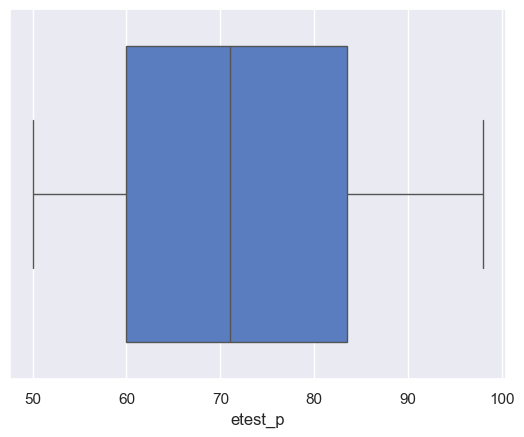

In [59]:
sns.boxplot(data=df, x='etest_p')

<Axes: xlabel='mba_p'>

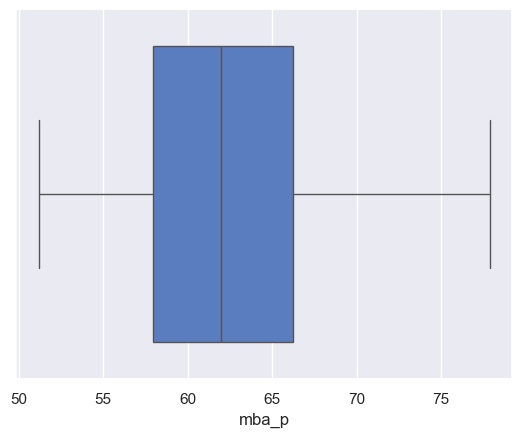

In [60]:
sns.boxplot(data=df, x='mba_p')

<Axes: xlabel='salary'>

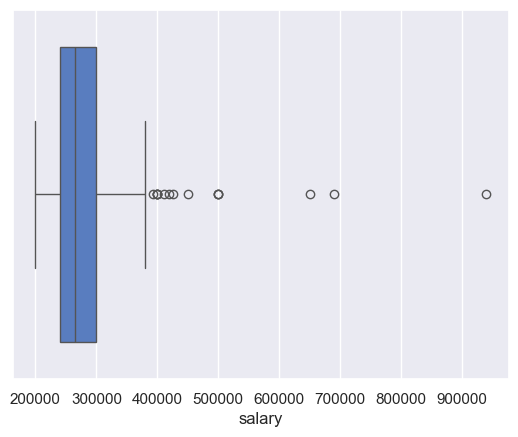

In [61]:
sns.boxplot(data=df, x='salary')

<Axes: xlabel='salary', ylabel='Count'>

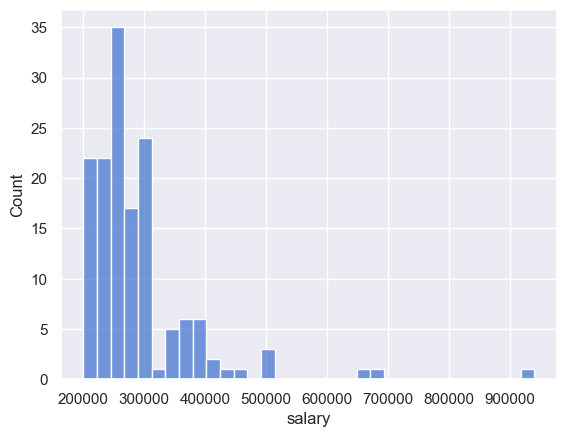

In [62]:
sns.histplot(data=df, x='salary')

[Text(0.5, 20.049999999999997, 'MBA Score'), Text(36.25, 0.5, 'Status')]

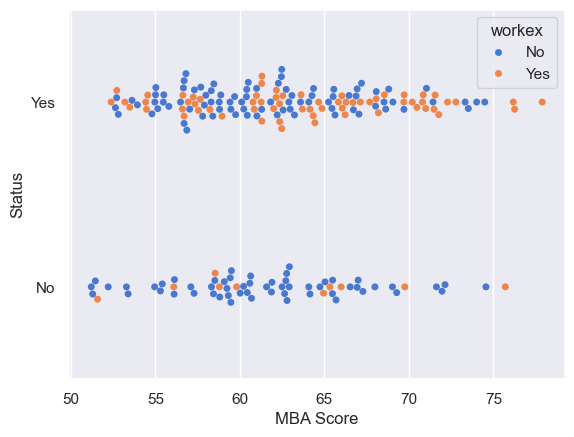

In [63]:
sns.set_theme(style="darkgrid", palette="muted")

ax = sns.swarmplot(data=df, x='mba_p', y='status', hue='workex')
ax.set(xlabel='MBA Score', ylabel='Status')

In [64]:
px.violin(df, y='salary', x='specialisation', color='gender', box=True, points='all')

Vamos agora fazer uma análise das correlações entre as variáveis

In [65]:
df_corr = df.select(
    pl.col([pl.Int64, pl.Float64, pl.Boolean])
).fill_null(0)

df_corr = df_corr.corr().insert_at_idx(0, pl.Series('colunas', df_corr.columns))
df_corr

colunas,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
str,f64,f64,f64,f64,f64,f64,f64
"""sl_no""",1.0,-0.078155,-0.085711,-0.088281,0.063636,0.022327,0.002543
"""ssc_p""",-0.078155,1.0,0.511472,0.538404,0.261993,0.388478,0.53809
"""hsc_p""",-0.085711,0.511472,1.0,0.434206,0.245113,0.354823,0.452569
"""degree_p""",-0.088281,0.538404,0.434206,1.0,0.22447,0.402364,0.408371
"""etest_p""",0.063636,0.261993,0.245113,0.22447,1.0,0.218055,0.186988
"""mba_p""",0.022327,0.388478,0.354823,0.402364,0.218055,1.0,0.139823
"""salary""",0.002543,0.53809,0.452569,0.408371,0.186988,0.139823,1.0


<Axes: ylabel='colunas'>

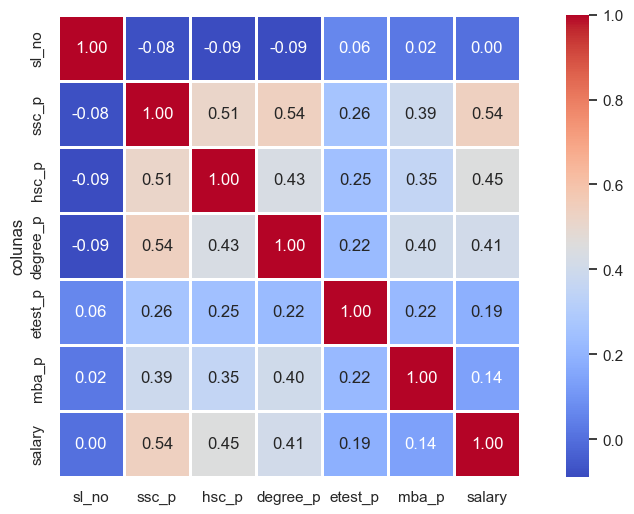

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    df_corr.to_pandas().set_index('colunas'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=1,
    ax=ax
)

Podemos fazer a correlação com as variáveis categóricas também através do LabelEncoder e HotEncoder.

In [93]:
df_aux = df
col_cat_le = ['gender', 'workex', 'specialisation', 'status']

le = LabelEncoder()

for c in col_cat_le:
    df_aux = df_aux.with_columns(
        pl.lit(le.fit_transform(df[c])).alias(c)
    )

df_aux.head()

sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
i64,i64,f64,str,f64,str,str,f64,str,i64,f64,i64,f64,i64,i64
1,1,67.0,"""Others""",91.0,"""Others""","""Commerce""",58.0,"""Sci&Tech""",0,55.0,1,58.8,1,270000
2,1,79.33,"""Central""",78.33,"""Others""","""Science""",77.48,"""Sci&Tech""",1,86.5,0,66.28,1,200000
3,1,65.0,"""Central""",68.0,"""Central""","""Arts""",64.0,"""Comm&Mgmt""",0,75.0,0,57.8,1,250000
4,1,56.0,"""Central""",52.0,"""Central""","""Science""",52.0,"""Sci&Tech""",0,66.0,1,59.43,0,null
5,1,85.8,"""Central""",73.6,"""Central""","""Commerce""",73.3,"""Comm&Mgmt""",0,96.8,0,55.5,1,425000


<Axes: ylabel='colunas'>

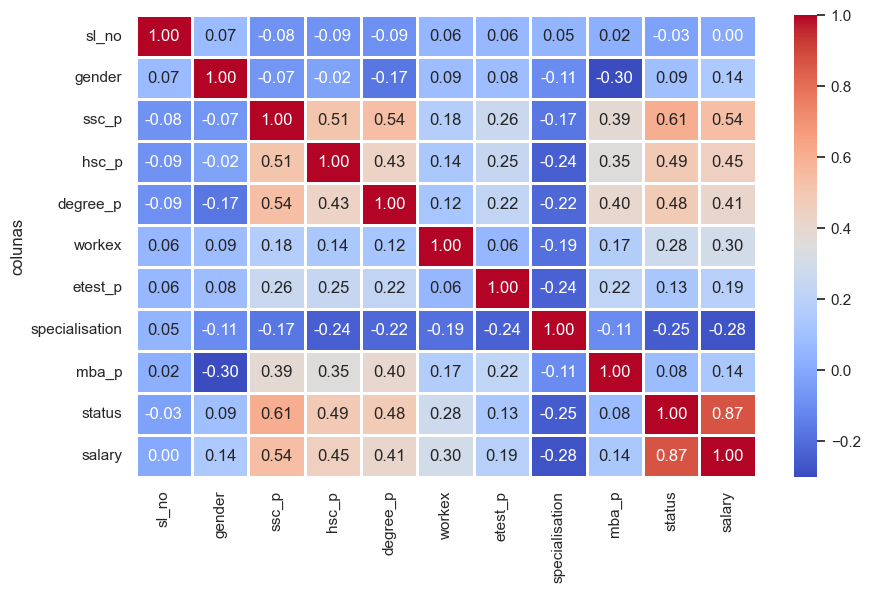

In [94]:
df_corr = df_aux.select(
    pl.col([pl.Int64, pl.Float64, pl.Boolean])
).fill_null(0)

df_corr = df_corr.corr().insert_at_idx(0, pl.Series('colunas', df_corr.columns))

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    df_corr.to_pandas().set_index('colunas'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=1,
    ax=ax
)

In [103]:
col_cat_dummy = ['ssc_b', 'hsc_b', 'hsc_s', 'degree_t']

df_aux = df_aux.to_dummies(columns=col_cat_dummy)
df_aux.sample(5)

sl_no,gender,ssc_p,ssc_b_Central,ssc_b_Others,hsc_p,hsc_b_Central,hsc_b_Others,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_p,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex,etest_p,specialisation,mba_p,status,salary
i64,i64,f64,u8,u8,f64,u8,u8,u8,u8,u8,f64,u8,u8,u8,i64,f64,i64,f64,i64,i64
18,0,55.0,1,0,67.0,1,0,0,1,0,64.0,1,0,0,0,60.0,0,67.28,0,null
7,0,46.0,0,1,49.2,0,1,0,1,0,79.0,1,0,0,0,74.28,0,53.29,0,null
43,1,49.0,0,1,39.0,1,0,0,0,1,65.0,0,1,0,0,63.0,0,51.21,0,null
71,1,82.0,0,1,61.0,0,1,0,0,1,62.0,0,0,1,0,89.0,0,65.45,1,360000
137,0,47.0,1,0,59.0,1,0,1,0,0,64.0,1,0,0,0,78.0,0,61.58,0,null


<Axes: ylabel='colunas'>

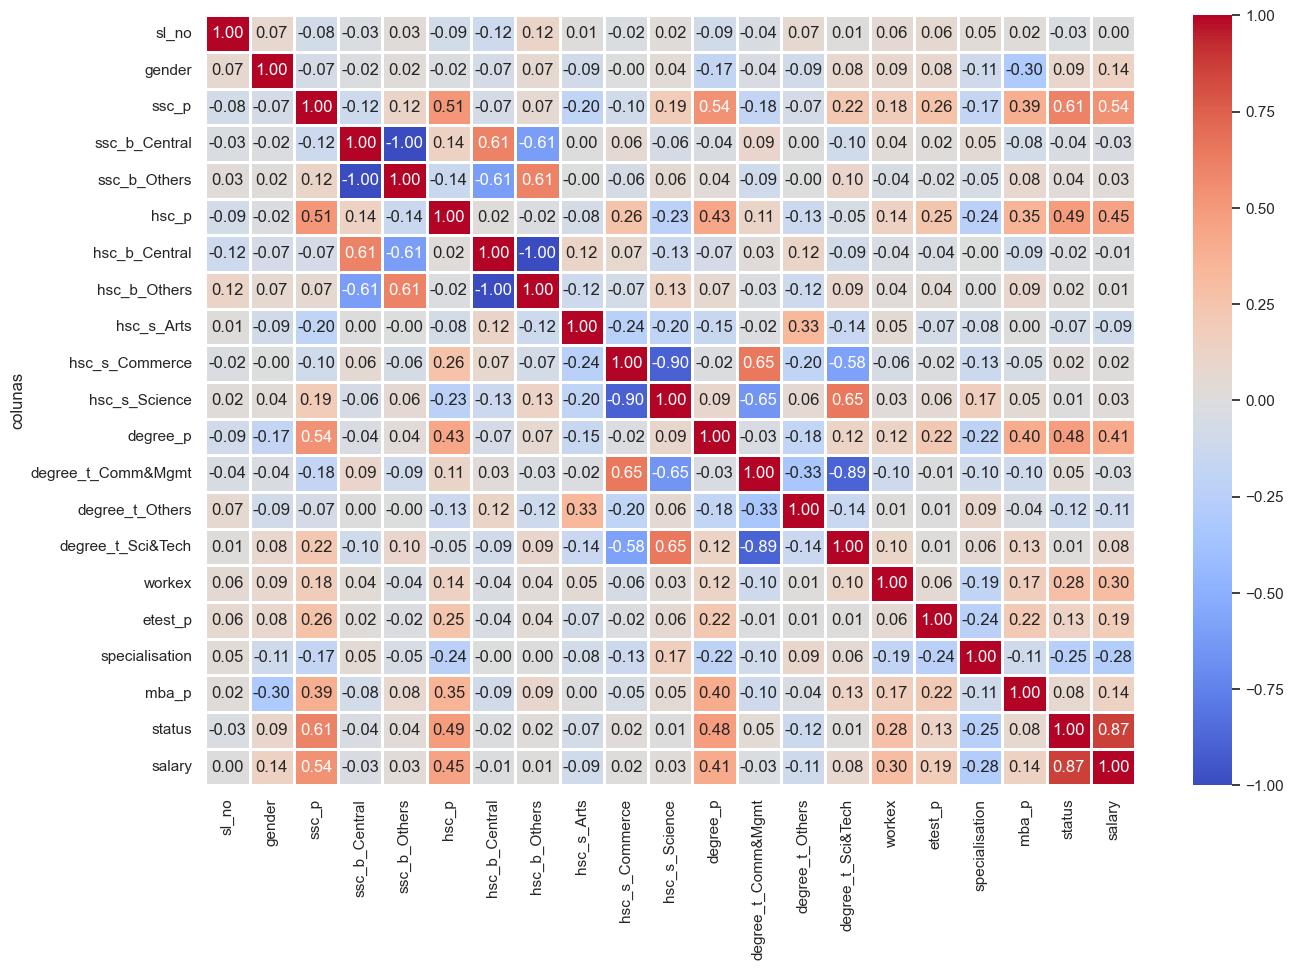

In [107]:
df_corr = df_aux.select(
    pl.col([pl.Int64, pl.Float64, pl.UInt8])
).fill_null(0)

df_corr = df_corr.corr().insert_at_idx(0, pl.Series('colunas', df_corr.columns))

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(
    df_corr.to_pandas().set_index('colunas'),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=1,
    ax=ax
)

# Treinando o modelo

In [119]:
X = df_aux.select(
    pl.col(['ssc_p', 'hsc_p', 'degree_p', 'workex', 'mba_p'])
)

y = df_aux.select('status')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

Precisamos agora normalizar os dados para que o modelo não seja enviesado por uma variável que tenha uma escala muito maior que as outras.

In [121]:
mms = MinMaxScaler()
mms.fit(X_train)

X_train_pad = mms.transform(X_train)
X_test_pad = mms.transform(X_test)

Para identificar o melhor número de vizinhos para o modelo, vamos avaliar a acurácia para cada k em um range.

In [137]:
error = []

for i in range(2, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_pad, y_train.to_numpy().flatten())
    y_hat = knn.predict(X_test_pad)
    error.append(np.mean(y_hat != y_test.to_numpy().flatten()))

Text(0, 0.5, 'Erro Médio')

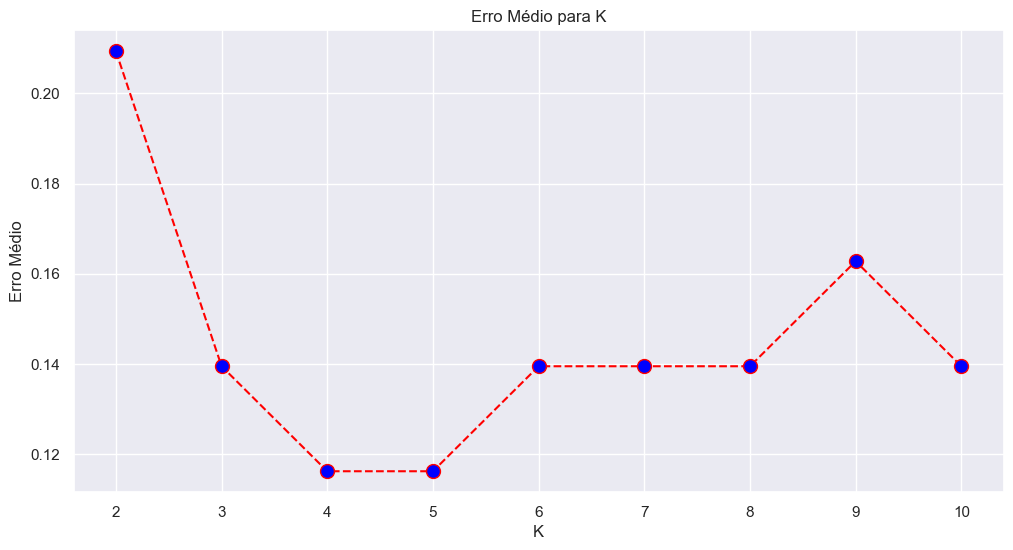

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)

plt.title('Erro Médio para K')
plt.xlabel('K')
plt.ylabel('Erro Médio')

Podemos ver que temos o menor erro médio com k igual a 4 e 5. Em modelos KNN é interessante escolhermos um número ímpar de vizinhos para evitar empates.

In [141]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pad, y_train.to_numpy().flatten())
y_hat = knn.predict(X_test_pad)

Vamos verificar as métricas do modelo

In [156]:
print(f"Acurácia: {accuracy_score(y_test.to_numpy().flatten(), y_hat):.2f}")
print(classification_report(y_test.to_numpy().flatten(), y_hat))

Acurácia: 0.88
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.88      0.97      0.92        30

    accuracy                           0.88        43
   macro avg       0.89      0.83      0.85        43
weighted avg       0.89      0.88      0.88        43



Vamos treinar uma SVM para comparar os resultados e escolher o melhor modelo. Vamos usar o Pipeline para fazer o pré-processamento dos dados e treinar o modelo.

In [154]:
pipe_svm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', LinearSVC(C=1, dual='auto'))
])

pipe_svm.fit(X_train, y_train.to_numpy().flatten())

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc', LinearSVC(C=1, dual='auto'))])

In [155]:
y_hat_svm = pipe_svm.predict(X_test)

Vamos agora avaliar as métricas do modelo

In [157]:
print(f"Acurácia: {accuracy_score(y_test.to_numpy().flatten(), y_hat_svm):.2f}")
print(classification_report(y_test.to_numpy().flatten(), y_hat_svm))

Acurácia: 0.86
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.88      0.93      0.90        30

    accuracy                           0.86        43
   macro avg       0.85      0.81      0.83        43
weighted avg       0.86      0.86      0.86        43

